<a href="https://colab.research.google.com/github/thissop/MAXI-J1535/blob/main/code/machine-learning/December-%202021-2022/RF_and_OLS_on_Updated_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RF and OLS on Updated Sample
## Notes
* Ah yes! Proof that the linear model is inadequate...grossly so if I do say so myself...in the paper I'm really looking forward to introducing the doubt of when machine learning models are really useful, and then pre-empting this doubt on my work by proving why linear models are inadequate in the case of my work 
    * It's interesting to note that the linear model fails by two counts: first, it is unable to recognize the situations with no QPOs based on spectral data input, and second, it has very high variance in its predictions of the features with QPO data. 
    * Although something that's really sus that I need to look into is why the norms and widths line up ... 👀
    * Something I want to do now is make sure that the inputs/outputs are train test split in such a way that we can directly compare the random forest/linear regression on the spectral PDS versus on the raw counts PDS...that would be very interesting. 
    * What's[link text](https://) left to do: broad features 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import r2_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain


plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')

rs = 4

qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/current_qpos.csv')

mask = np.where(np.isfinite(qpo_df['num_qpos']))
qpo_df = qpo_df.iloc[mask]

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/wrangled_nthcomp_spectral_data.csv')

merged_df = qpo_df.merge(spectral_df, left_on='full_id', right_on='full_ids').sample(frac=1, random_state=rs)
merged_df = merged_df.fillna(0)

## XSPEC Inputs

In [12]:
# methods

def norm(x, min, max): 
    return (x - min) / (max - min)

def unnorm(x_, min, max):
    return x_*(max-min)+min

In [3]:
# usual x values way 


# x values
x_vals = np.array([], dtype=float).reshape(0,5) 
arr_names =  ['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate'] #reduced_fit_stat
(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts) = (normalize(np.array(merged_df[arr_name])) for arr_name in arr_names)

for a, b, c, d, e, in zip(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e)])
    x_vals = np.vstack([x_vals, new_arr])


# just checking for multicolinearity solution help --> doesn't help let's go 
'''
# x values
x_vals = np.array([], dtype=float).reshape(0,1) 
arr_names =  ['nthcomp_norm_before_error'] #reduced_fit_stat
nthcomp_norms = normalize(np.array(merged_df['nthcomp_norm_before_error']))

for a in nthcomp_norms: 
    new_arr = np.array([float(a)])
    x_vals = np.vstack([x_vals, new_arr])
'''
# y values 
# normalize all freqs according to same function ---- THIS IS SO MESSY I KNOW...I AM SORRY 
combined_freqs = np.concatenate((merged_df['first_freq'], merged_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((merged_df['first_width'], merged_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((merged_df['first_norm'], merged_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(merged_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(merged_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(merged_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.1, shuffle=True, random_state=rs)

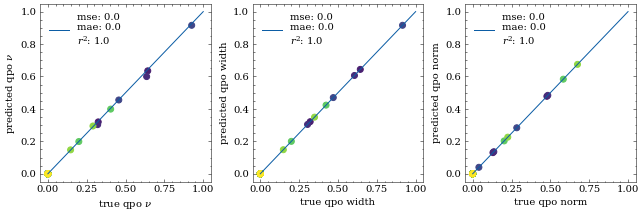

In [5]:
# Random Forest on spectral inputs 

regr = RandomForestRegressor()
regr.fit(X_train,y_train)

predictions = regr.predict(X_test)
predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]
rsqs = [r2_score(test_freqs, predicted_freqs), r2_score(test_widths, predicted_widths), r2_score(test_norms, predicted_norms)]
fig, axs = plt.subplots(1, 3, figsize=(9,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax = axs[0]
ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax = axs[1]
ax.scatter(test_widths, predicted_widths, c=colors)
ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

ax = axs[2]
ax.scatter(test_norms, predicted_norms, c=colors)
ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

for i in range(3):  
    ax = axs[i]
    mse = mses[i]
    mae = maes[i]
    rsq = rsqs[i]
    line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))+'\n'+r'$r^2$'+': '+str(round(rsq, 2))
    ax.plot([0,1], [0,1], label=line_label)
    ax.legend()
    
plt.show()

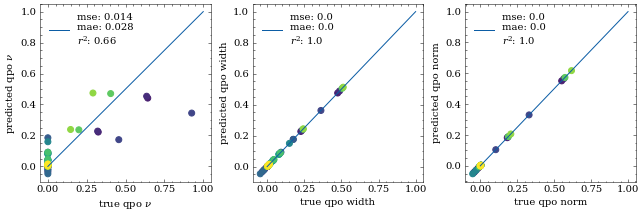

In [6]:
# linear model on spectral inputs 

#model = Ridge(alpha=0.1)
model = LinearRegression()
#wrapper = RegressorChain(model, order=[0,1])

model.fit(X=X_train, y=y_train)

predictions = model.predict(X_test)

predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]
rsqs = [r2_score(test_freqs, predicted_freqs), r2_score(test_widths, predicted_widths), r2_score(test_norms, predicted_norms)]

fig, axs = plt.subplots(1, 3, figsize=(9,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax = axs[0]
ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax = axs[1]
ax.scatter(test_widths, predicted_widths, c=colors)
ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

ax = axs[2]
ax.scatter(test_norms, predicted_norms, c=colors)
ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

for i in range(3):  
    ax = axs[i]
    mse = mses[i]
    mae = maes[i]
    rsq = rsqs[i]
    line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))+'\n'+r'$r^2$'+': '+str(round(rsq, 2))
    ax.plot([0,1], [0,1], label=line_label)
    ax.legend()
    
plt.show()

## Raw Spectral Data Inputs

In [7]:
!pip install rebin
import pandas as pd 
import numpy as np
from rebin import rebin 

import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/count_rates_initial_exploration/count_rates_transposed.csv')
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/current_qpos.csv').fillna(0)


spectral_df.sort_values(by='full_id')
qpo_df.sort_values(by='full_id')

mask = np.where(np.isfinite(qpo_df['num_qpos']))

qpo_df = qpo_df.iloc[mask]

spectral_indices = []
for i in qpo_df['full_id']: 
    spectral_indices.append(np.where(spectral_df['full_id']==i)[0][0])

spectral_df = spectral_df.iloc[spectral_indices]

for i in ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']: 
    qpo_df = qpo_df.astype({i:float})

for i, j in zip(qpo_df['full_id'], spectral_df['full_id']): 
    if i!=j: 
        print('mis-match')
        print(i,j)

In [8]:
# package x values

bins = 25

x = []

for i in range(len(spectral_df.index)): 
    counts_row = np.array(spectral_df.iloc[[i]])[0][1:].astype(float) 
    
    rebin_factor = int(np.floor(len(counts_row)/bins))
    
    rebined = rebin(counts_row, rebin_factor)
    x.append(rebined)

x = np.array(x)

# package y values

combined_freqs = np.concatenate((qpo_df['first_freq'], qpo_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((qpo_df['first_width'], qpo_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((qpo_df['first_norm'], qpo_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(qpo_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(qpo_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(qpo_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y_vals, test_size=0.1, shuffle=True, random_state=rs)

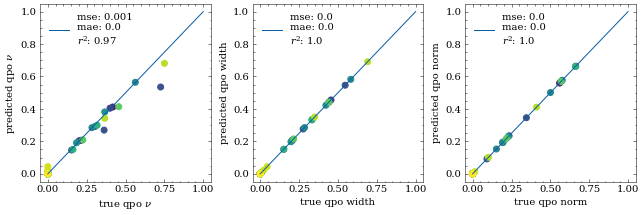

In [31]:
# Random Forest on spectral inputs 

regr = RandomForestRegressor()
regr.fit(X_train,y_train)

predictions = regr.predict(X_test)
predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]
rsqs = [r2_score(test_freqs, predicted_freqs), r2_score(test_widths, predicted_widths), r2_score(test_norms, predicted_norms)]
fig, axs = plt.subplots(1, 3, figsize=(9,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax = axs[0]
ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax = axs[1]
ax.scatter(test_widths, predicted_widths, c=colors)
ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

ax = axs[2]
ax.scatter(test_norms, predicted_norms, c=colors)
ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

for i in range(3):  
    ax = axs[i]
    mse = mses[i]
    mae = maes[i]
    rsq = rsqs[i]
    line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))+'\n'+r'$r^2$'+': '+str(round(rsq, 2))
    ax.plot([0,1], [0,1], label=line_label)
    ax.legend()
    
plt.show()

unnorm_rf_test, unnorm_rf_pred = (unnorm(i, min_freq, max_freq).flatten() for i in (test_freqs, predicted_freqs))

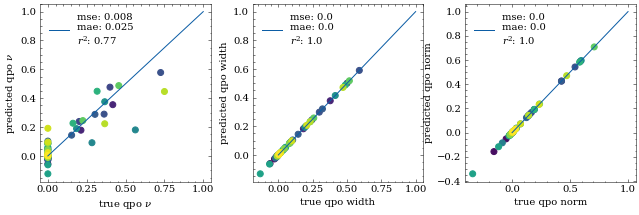

In [33]:
# linear model on spectral inputs 

#model = Ridge(alpha=0.1)
model = LinearRegression()
#wrapper = RegressorChain(model, order=[0,1])

model.fit(X=X_train, y=y_train)

predictions = model.predict(X_test)

predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]
rsqs = [r2_score(test_freqs, predicted_freqs), r2_score(test_widths, predicted_widths), r2_score(test_norms, predicted_norms)]

fig, axs = plt.subplots(1, 3, figsize=(9,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax = axs[0]
ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax = axs[1]
ax.scatter(test_widths, predicted_widths, c=colors)
ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

ax = axs[2]
ax.scatter(test_norms, predicted_norms, c=colors)
ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

for i in range(3):  
    ax = axs[i]
    mse = mses[i]
    mae = maes[i]
    rsq = rsqs[i]
    line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))+'\n'+r'$r^2$'+': '+str(round(rsq, 2))
    ax.plot([0,1], [0,1], label=line_label)
    ax.legend()
    
plt.show()

unnorm_ols_test, unnorm_ols_pred = (unnorm(i, min_freq, max_freq).flatten() for i in (test_freqs, predicted_freqs))

## How Much Unnormalized Frequencies Differ

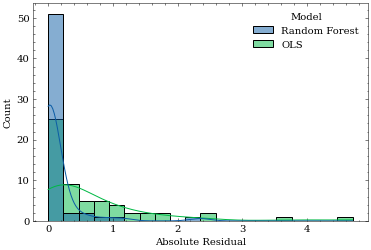

In [70]:
#min_freq, max_freq
#plt.scatter(unnorm_test, unnorm_pred)

#print(unnorm_test[0:8],unnorm_pred[0:8])
import seaborn as sns

ols_diffs = np.abs(unnorm_ols_test-unnorm_ols_pred)
#sns.histplot(ols_diffs, label=str(np.mean(ols_diffs)), bins=10)

rf_diffs = np.abs(unnorm_rf_test-unnorm_rf_pred)

df = pd.DataFrame({'Absolute Residual':np.concatenate((rf_diffs, ols_diffs)),
                   'Model':len(rf_diffs)*['Random Forest']+len(ols_diffs)*['OLS']})

sns.histplot(df, x='Absolute Residual', hue='Model', bins=20, kde=True)

In [71]:
from scipy import stats

print(stats.ks_2samp(ols_diffs, rf_diffs, alternative='less')) 
#less: The null hypothesis is that F(x) >= G(x) for all x; the alternative is that F(x) < G(x) for at least one x.

Ks_2sampResult(statistic=0.6206896551724138, pvalue=4.520648816374015e-11)
